<img src='../img/bimbo.png'>

- Task: Demand = Sales - Returns
- Create holdout test set

## Data exploration

In [1]:
#jupyter nbconvert --to python "Bimbo Bread Py.ipynb"

import pandas as pd
import numpy as np
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import operator

dir_sub = "C:/Users/568377/Cognizant/Data Science/kaggle/Bimbo Bread/submissions/"
dir_raw = "C:/Users/568377/Cognizant/Data Science/kaggle/Bimbo Bread/raw/"

In [4]:
subm = pd.read_csv(os.path.join(dir_raw,"sample_submission.csv"))
prod = pd.read_csv(os.path.join(dir_raw,"producto_tabla.csv"))
town_state = pd.read_csv(os.path.join(dir_raw,"town_state.csv"))
client = pd.read_csv(os.path.join(dir_raw,"cliente_tabla.csv"))
test = pd.read_csv(os.path.join(dir_raw,"test.csv"), nrows = 10000)
train = pd.read_csv(os.path.join(dir_raw,"train.csv"), nrows = 10000)

In [3]:
print("Reading test data...")
test = pd.read_csv(os.path.join(dir_raw,"test.csv"))
print("Done")

Reading test data...
Done


In [3]:
print("Reading train data...")
train_1 = pd.read_csv(os.path.join(dir_raw,"train/xaa"))
print("...1. batch finished...")
train_2 = pd.read_csv(os.path.join(dir_raw,"train/xab"))
print("...2. batch finished...")
print("Done")

Reading train data...
first batch finished
second batch finished
Done


In [4]:
train = pd.concat([train_1,train_2]) # not working properly

In [7]:
train.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


In [11]:
train.dtypes

Semana                 int64
Agencia_ID             int64
Canal_ID               int64
Ruta_SAK               int64
Cliente_ID             int64
Producto_ID            int64
Venta_uni_hoy          int64
Venta_hoy            float64
Dev_uni_proxima        int64
Dev_proxima          float64
Demanda_uni_equil      int64
dtype: object

In [5]:
import sqlite3

dbfile = os.path.join(dir_raw,"train/train.sqlite")
cxn = sqlite3.connect(dbfile)
c = cxn.cursor()

In [9]:
train_1.to_sql(name='train_1', con = cxn, if_exists='replace')
train_2.to_sql(name='train_2', con = cxn, if_exists='replace')

In [10]:
strSQL = 'SELECT * FROM train_1 UNION SELECT * FROM train_2;'
# MIGHT HAVE TO ADJUST ABOVE FOR CELL AND PATIENT PARAMS IN DEFINED FUNCTION

merged = pd.read_sql(strSQL, cxn)

MemoryError: 

### Features

#### Product

In [4]:
# prod.head()

In [5]:
# extract weight and volume from product name
prod['unit_g'] = prod['NombreProducto'].str.extract("([0-9]+)(g )", expand=True)[1]
prod['amount_g'] = prod['NombreProducto'].str.extract("([0-9]+)(g )", expand=True)[0]
prod['unit_ml'] = prod['NombreProducto'].str.extract("([0-9]+)(ml )", expand=True)[1]
prod['amount_ml'] = prod['NombreProducto'].str.extract("([0-9]+)(ml )", expand=True)[0]

# make numeric
prod['amount_g'] = prod['amount_g'].convert_objects(convert_numeric=True)
prod['amount_ml'] = prod['amount_ml'].convert_objects(convert_numeric=True)

c:\users\568377\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
c:\users\568377\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [6]:
# prod

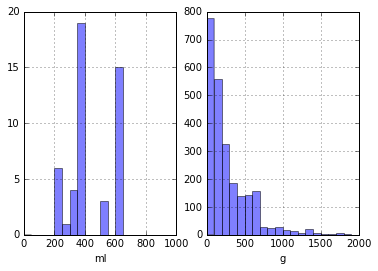

In [7]:
# show distribution of weight / volume
fig, axs = plt.subplots(1,2)
bins_ml=[i for i in range(0,1000,50)]
bins_g=[i for i in range(0,2000,100)]

prod['amount_ml'].hist(ax=axs[0],bins=bins_ml,alpha=0.5)
axs[0].set_xlabel("ml")
prod['amount_g'].hist(ax=axs[1],bins=bins_g,alpha=0.5)
axs[1].set_xlabel("g")

# NEXT STEPS
- Categorize food
- Quota of large items
- How new is item?

#### Town/State

In [8]:
# town_state.head()

In [9]:
# make lowercase
town_state['Town'] = town_state['Town'].str.lower()
town_state['State'] = town_state['State'].str.lower()
# separate zip, town_name
town_state['zip'] = town_state['Town'].str[:4]
town_state['town_name'] = town_state['Town'].str[5:]

In [10]:
# town_state.head()

In [11]:
# check uniques
# len(town_state['Town'].unique()), len(town_state['zip'].unique()), len(town_state['town_name'].unique())
##town_state = town_state.groupby('zip')
##town_state['Town'].str[4].unique() -> clean

In [12]:
# twice, similar zips have different town_names
df = town_state.groupby('zip').Town.nunique()
df[df==2] #3 entries with different town names
double_town_names = np.array(df[df==2].index)
double_town_names # zips

array(['2152', '2169'], dtype=object)

In [13]:
town_state['zip'].max() #max zip number

'3216'

In [14]:
town_state[town_state['zip'] == double_town_names[0]]

,Agencia_ID,Town,State,zip,town_name
199,1524,2152 cruce de anden noroeste,baja california norte,2152,cruce de anden noroeste
371,2022,2152 altamirano_bm,guerrero,2152,altamirano_bm
583,21529,2152 altamirano_bm,guerrero,2152,altamirano_bm


In [15]:
town_state.loc[199,'zip']=9999
town_state.loc[199,'Town']="9999 cruce de anden noroeste"
town_state[town_state['zip'] == 9999]

,Agencia_ID,Town,State,zip,town_name
199,1524,9999 cruce de anden noroeste,baja california norte,9999,cruce de anden noroeste


In [16]:
town_state[town_state['zip'] == double_town_names[1]]

,Agencia_ID,Town,State,zip,town_name
311,1694,2169 cruce de andén sureste,puebla,2169,cruce de andén sureste
372,2023,2169 pinotepa,oaxaca,2169,pinotepa
599,21699,2169 pinotepa,oaxaca,2169,pinotepa


In [17]:
town_state.loc[311,'zip']=9998
town_state.loc[311,'Town']="9998 cruce de andén sureste"
town_state[town_state['zip'] == 9998]

,Agencia_ID,Town,State,zip,town_name
311,1694,9998 cruce de andén sureste,puebla,9998,cruce de andén sureste


In [18]:
# town_state.head()

In [19]:
# len(town_state['Town'].unique()), len(town_state['zip'].unique()), len(town_state['town_name'].unique())

In [20]:
df1 = town_state.groupby('town_name').zip.nunique()

In [21]:
df1[df1==2]

town_name
los mochis    2
pinotepa      2
Name: zip, dtype: int64

In [22]:
df1[df1==2] #3 entries with different town names
double_zip_names = np.array(df1[df1==2].index)
double_zip_names # zips

array(['los mochis', 'pinotepa'], dtype=object)

In [23]:
town_state[town_state['town_name'] == double_zip_names[0]] #towns can have multiple zip codes!!! :)

,Agencia_ID,Town,State,zip,town_name
211,1544,2561 los mochis,sinaloa,2561,los mochis
227,1564,2561 los mochis,sinaloa,2561,los mochis
248,1598,2561 los mochis,sinaloa,2561,los mochis
498,2655,2655 los mochis,sinaloa,2655,los mochis
774,25619,2561 los mochis,sinaloa,2561,los mochis


In [24]:
town_state[town_state['town_name'] == double_zip_names[1]] #ID 387 interferes with town_name. If town_name big effect, look here. Test here for improvement.

,Agencia_ID,Town,State,zip,town_name
372,2023,2169 pinotepa,oaxaca,2169,pinotepa
387,2055,2055 pinotepa,puebla,2055,pinotepa
599,21699,2169 pinotepa,oaxaca,2169,pinotepa


In [25]:
# town_state.head()

In [26]:
# Create new category city type:
town_state['town_name_corpus'] = town_state['town_name']
town_state['town_name_type'] = ""

In [27]:
# add town_name_type and add "ag"
town_state.loc[town_state['town_name_corpus'].str[:4] == "ag. ", 'town_name_type'] = "ag"
# remove ag from town_name_corpus
town_state.loc[town_state['town_name_corpus'].str[:4] == "ag. ", 'town_name_corpus'] = town_state.loc[town_state['town_name_corpus'].str[:4] == "ag. ", 'town_name_corpus'].str[4:]

town_state.loc[town_state['town_name_corpus'].str[:3] == "ag.", 'town_name_type'] = "ag"
town_state.loc[town_state['town_name_corpus'].str[:3] == "ag.", 'town_name_corpus'] = town_state.loc[town_state['town_name_corpus'].str[:3] == "ag.", 'town_name_corpus'].str[3:]

town_state.loc[town_state['town_name_corpus'].str[:4] == "cd. ", 'town_name_type'] = "cd"
town_state.loc[town_state['town_name_corpus'].str[:4] == "cd. ", 'town_name_corpus'] = town_state.loc[town_state['town_name_corpus'].str[:4] == "cd. ", 'town_name_corpus'].str[4:]

In [28]:
#town_state.head()
#sorted(town_state['town_name'].str[:30].unique())

#### Client

In [29]:
#client = pd.read_csv(os.path.join(dir_raw,"cliente_tabla.csv"))
client.tail()
#len(client)

,Cliente_ID,NombreCliente
935357,11011586,OXXO PETEN
935358,11693264,SUPER ABARROTES MARY
935359,19988629,NO IDENTIFICADO
935360,99999999,NO IDENTIFICADO
935361,2015152015,NO IDENTIFICADO


In [30]:
"""client['NombreCliente'] = client['NombreCliente'].str.lower()
client = pd.read_csv(os.path.join(dir_raw,"cliente_tabla.csv"))
client = client.groupby(['Cliente_ID', 'NombreCliente'])
#client = client.drop_duplicates(subset=['Cliente_ID', 'NombreCliente'], keep=False)
client.tail()
len(client)

df1 = client.groupby('Cliente_ID').NombreCliente.nunique()
df1[df1!=1]

testclient = client[client['Cliente_ID'] == 4]
testclient

testclient.loc[4]['NombreCliente'] == testclient.loc[5]['NombreCliente']
"""

'client[\'NombreCliente\'] = client[\'NombreCliente\'].str.lower()\nclient = pd.read_csv(os.path.join(dir_raw,"cliente_tabla.csv"))\nclient = client.groupby([\'Cliente_ID\', \'NombreCliente\'])\n#client = client.drop_duplicates(subset=[\'Cliente_ID\', \'NombreCliente\'], keep=False)\nclient.tail()\nlen(client)\n\ndf1 = client.groupby(\'Cliente_ID\').NombreCliente.nunique()\ndf1[df1!=1]\n\ntestclient = client[client[\'Cliente_ID\'] == 4]\ntestclient\n\ntestclient.loc[4][\'NombreCliente\'] == testclient.loc[5][\'NombreCliente\']\n'

In [31]:
test.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305
1,1,11,2237,1,1226,4705135,1238
2,2,10,2045,1,2831,4549769,32940
3,3,11,1227,1,4448,4717855,43066
4,4,11,1219,1,1130,966351,1277


In [32]:
train.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


## Merge product ID, train

In [33]:
train.tail()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
499995,3,1120,1,2116,1182439,31588,1,11.53,0,0.0,1
499996,3,1120,1,2116,1182439,35841,4,27.68,0,0.0,4
499997,3,1120,1,2116,1182439,36746,2,23.06,0,0.0,2
499998,3,1120,1,2116,1182439,36747,1,11.53,0,0.0,1
499999,3,1120,1,2116,1243274,30532,3,23.34,0,0.0,3


In [34]:
train = pd.read_csv(os.path.join(dir_raw,"train.csv"), nrows=500000)
test = pd.read_csv(os.path.join(dir_raw,"test.csv"), nrows=500000)

In [35]:
train = pd.merge(train, prod, on='Producto_ID', how='left')
train = pd.merge(train, town_state, on='Agencia_ID', how='left')
#train = pd.merge(train, client, on='Cliente_ID', how='left') # no 

test = pd.merge(test, prod, on='Producto_ID', how='left')
test = pd.merge(test, town_state, on='Agencia_ID', how='left')
#test = pd.merge(test, client, on='Cliente_ID', how='left') # no 

# XGBOOST

https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2/code

In [36]:
features = ['Semana',
 'Agencia_ID',
 'Canal_ID',
 'Ruta_SAK',
 'Cliente_ID',
 'Producto_ID',
 #'Venta_uni_hoy',
 #'Venta_hoy',
 #'Dev_uni_proxima',
 #'Dev_proxima',
 #'Demanda_uni_equil',
 'amount_g',
 'amount_ml']

In [37]:
#replace nan
train=train.fillna(-999)
test=test.fillna(-999)

In [38]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 300

In [39]:
print("Train a XGBoost model")
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = X_train.Demanda_uni_equil
y_valid = X_valid.Demanda_uni_equil
dtrain = xgb.DMatrix(X_train[features], y_train, missing=-999)
dvalid = xgb.DMatrix(X_valid[features], y_valid, missing=-999)


Train a XGBoost model


In [42]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100,  verbose_eval=True) # add feval=rmspe_xg for scoring

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmse:15.896315	eval-rmse:18.789330
[1]	train-rmse:14.089788	eval-rmse:17.607273
[2]	train-rmse:12.557151	eval-rmse:16.456392
[3]	train-rmse:11.718679	eval-rmse:15.856224
[4]	train-rmse:10.773622	eval-rmse:15.425581
[5]	train-rmse:10.425425	eval-rmse:15.245467
[6]	train-rmse:9.900363	eval-rmse:14.796491
[7]	train-rmse:9.766807	eval-rmse:14.702899
[8]	train-rmse:9.522253	eval-rmse:14.657779
[9]	train-rmse:9.340682	eval-rmse:14.579513
[10]	train-rmse:9.026814	eval-rmse:14.413356
[11]	train-rmse:8.794036	eval-rmse:14.378044
[12]	train-rmse:8.762915	eval-rmse:14.371868
[13]	train-rmse:8.594522	eval-rmse:14.411255
[14]	train-rmse:8.422456	eval-rmse:14.409367
[15]	train-rmse:8.275208	eval-rmse:14.333763
[16]	train-rmse:8.188867	eval-rmse:14.333721
[17]	train-rmse:8.078202	eval-rmse:14.174934
[18]	train-rmse:8.065357	eval-rmse:14.168135
[19]	train-rmse:8.022655	eval-rmse:14.164859
[20]	train-rmse:7.985723	eval-rmse:14.173925

In [ ]:
#print("Validating")
#yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
#error = rmspe(X_valid.Sales.values, np.expm1(yhat))
#print('RMSPE: {:.6f}'.format(error))

print("Make predictions on the test set")
dtest = xgb.DMatrix(test[features])
test_probs = gbm.predict(dtest)

In [65]:
# Make Submission
result = pd.DataFrame({'id': test['id'], 'Demanda_uni_equil': test_probs})
result = result[['id','Demanda_uni_equil']]
result.to_csv(os.path.join(dir_sub, "submission_4.csv"), cols=["id","Demanda_uni_equil"], index=False)

In [66]:
result.head()

,id,Demanda_uni_equil
0,0,3.799973
1,1,2.022983
2,2,0.763591
3,3,5.723403
4,4,8.690198


In [67]:
resultcsv = pd.read_csv(os.path.join(dir_sub,"submission_5.csv"))

In [68]:
resultcsv.head()

,id,Demanda_uni_equil
0,0,3.799973
1,1,2.022983
2,2,0.763591
3,3,5.723403
4,4,8.690198


# NEXT STEPS

In [ ]:
"""# onehotencode categorical features
from sklearn.preprocessing import OneHotEncoder
>>> enc = OneHotEncoder()

# run script in command line
"""

http://nbviewer.jupyter.org/github/JohanManders/ROSSMANN-KAGGLE/blob/master/ROSSMANN%20STORE%20SALES%20COMPETITION%20KAGGLE.ipynb

# Archive

#### sub2

In [85]:
train = pd.read_csv(os.path.join(dir_raw,"sample_submission.csv"))

In [86]:
train["Demanda_uni_equil"]=6

In [87]:
train.to_csv(os.path.join(dir_sub, "submission_2.csv"), index=False)